## Clustering Models for Task 4 - Estimate the Energy Availability

**Task Goal:** </p>
Members from task 4 extracted solar source data and computed for the PVOut for each barangay. This represents the average estimated energy that can be produced by a single diode solar panel and the 41,933 barangays were clusted based on this. 

Three models were considered for this tasks: K Means Clustering, Density-based spatial clustering of applications with noise (DBScan), and Gaussian Mixture Modeling (GMM)
The final clustering model to be used on the data was based on their silhoutte scores </p>

### Libraries and importing of Data

In [37]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geojson import Point, Feature, FeatureCollection, dump

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score

from scipy.spatial.distance import cdist

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

In [2]:
ph = gpd.read_file('pvout_comp_and_wb.geojson')
ph.head()

,ID_0,ID_1,ID_2,ID_3,ISO,NAME_0,NAME_1,NAME_2,NAME_3,NL_NAME_3,WB_PVOUT_MIN,WB_PVOUT_MAX,WB_PVOUT_MEAN,COMP_PVOUT_MIN,COMP_PVOUT_MAX,COMP_PVOUT_MEAN,geometry
0,177,1,16,172,PHL,Philippines,Abra,Manabo,San Jose Norte,None,1609.291992,1631.937012,1623.170833,1507.666263,1650.392757,1623.132076,"MULTIPOLYGON (((120.70043 17.45648, 120.70312 ..."
1,177,1,16,173,PHL,Philippines,Abra,Manabo,San Jose Sur,None,1606.369019,1624.996948,1617.967421,1566.104092,1640.073805,1615.172807,"MULTIPOLYGON (((120.74783 17.44496, 120.74841 ..."
2,177,1,16,174,PHL,Philippines,Abra,Manabo,San Juan Norte,None,1611.848022,1640.703003,1622.878809,1534.882446,1639.468316,1607.814531,"MULTIPOLYGON (((120.69788 17.43542, 120.70522 ..."
3,177,1,16,175,PHL,Philippines,Abra,Manabo,San Juan Sur,None,1604.542969,1632.302002,1619.031331,1508.824457,1629.912552,1594.887200,"MULTIPOLYGON (((120.66516 17.42832, 120.70497 ..."
4,177,1,16,176,PHL,Philippines,Abra,Manabo,San Ramon East,None,1535.510986,1603.447998,1570.199021,1322.185031,1613.292239,1494.393054,"MULTIPOLYGON (((120.70567 17.42277, 120.76253 ..."


### Preparation of Data for Training Clustering Models

In [4]:
nan_index = ph.index[ph.COMP_PVOUT_MEAN.isnull()].values
# Impute based on Location
for index in nan_index:
    loc_name = ph.loc[index,"NAME_2"]
    imputed_value = ph[ph['NAME_2'] == loc_name].mean().values[0]
    ph.loc[index,'COMP_PVOUT_MEAN'] = imputed_value

In [5]:
pv_out = ph['COMP_PVOUT_MEAN']
pv_out = pv_out.to_numpy()
pv_out = pv_out.reshape(-1,1)
scaler = RobustScaler()
pv_out= scaler.fit_transform(pv_out)

### KMeans Clustering Model 

In [6]:
distortions = []
distortion_map = {}

inertias = []
inertia_map = {}

silhouette_scores = []

K = range(2, 20)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters = k, max_iter=300, random_state = 1234)
    kmeans.fit(pv_out)
    
    # Distortions 
    distortions.append(sum(np.min(cdist(pv_out, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / pv_out.shape[0])
    distortion_map[k] = sum(np.min(cdist(pv_out, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / pv_out.shape[0]
    
    # Inertia
    inertias.append(kmeans.inertia_)
    inertia_map[k] = kmeans.inertia_
    
    pred_clusters = kmeans.predict(pv_out)
    silhouette = silhouette_score(pv_out,pred_clusters)
    silhouette_scores.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))

Silhouette score for number of cluster(s) 2: 0.5467127543127276
Silhouette score for number of cluster(s) 3: 0.5178876068017472
Silhouette score for number of cluster(s) 4: 0.5401374499863606
Silhouette score for number of cluster(s) 5: 0.5344173351544149
Silhouette score for number of cluster(s) 6: 0.5317546842818052
Silhouette score for number of cluster(s) 7: 0.5379966894660175
Silhouette score for number of cluster(s) 8: 0.5271786556375853
Silhouette score for number of cluster(s) 9: 0.5300633159507209
Silhouette score for number of cluster(s) 10: 0.5270770930623125
Silhouette score for number of cluster(s) 11: 0.5235991230273138
Silhouette score for number of cluster(s) 12: 0.5224878172222334
Silhouette score for number of cluster(s) 13: 0.5238319842055338
Silhouette score for number of cluster(s) 14: 0.52493583592873
Silhouette score for number of cluster(s) 15: 0.5284371857219822
Silhouette score for number of cluster(s) 16: 0.5207198984329312
Silhouette score for number of clus

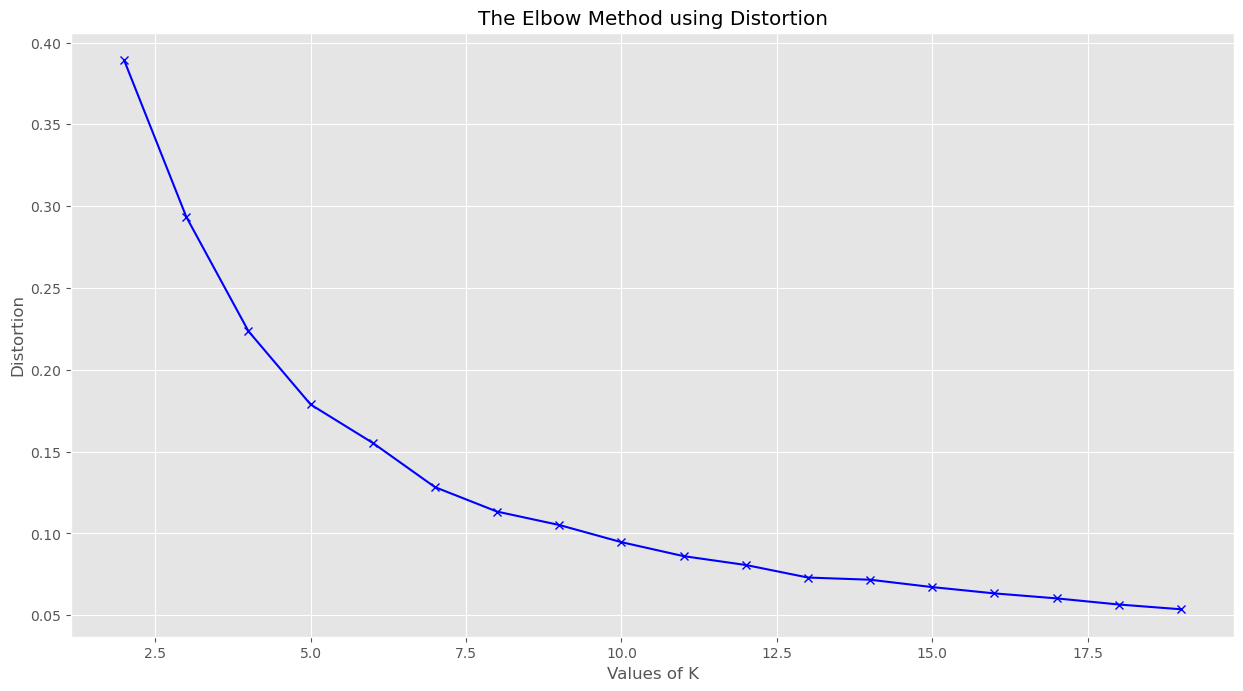

In [7]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

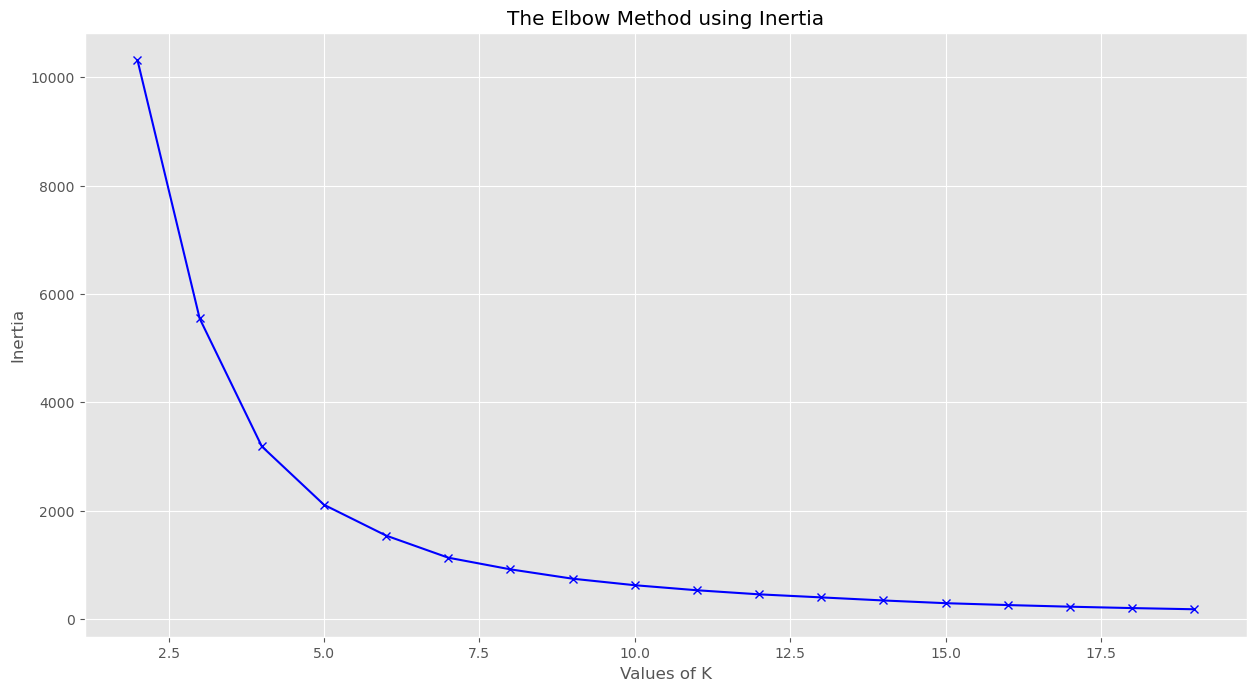

In [8]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

**k= 4 Silhouette score: 0.5401374499863606**

In [17]:
km_4 = KMeans(n_clusters=4, max_iter=300, random_state = 1234)
km_4.fit(pv_out)

KMeans(n_clusters=4, random_state=1234)

In [18]:
ph_cluster_4 = ph.copy()
ph_cluster_4['Cluster'] = km_4.labels_ + 1

Text(0.5, 1.0, 'Barangays Clustered for PVOUT')

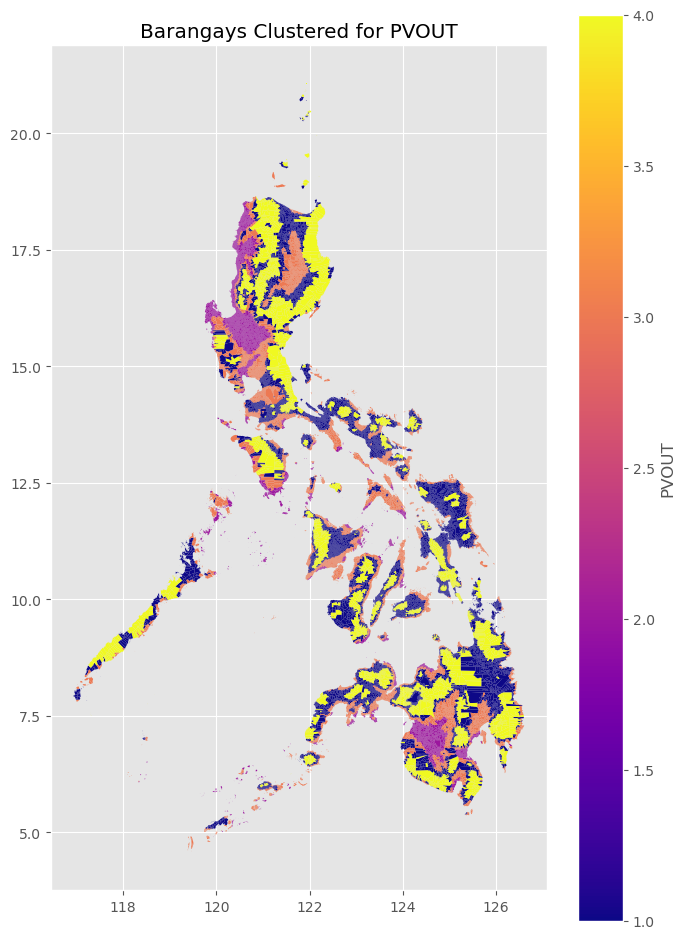

In [19]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_4.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Barangays Clustered for PVOUT')

In [21]:
ph_cluster_4.to_file(driver='GeoJSON', filename = "ph_clustered_4.geojson")

In [22]:
ph_cluster_4.to_file(driver = 'ESRI Shapefile', filename= "ph_clustered_4.shp")

In [86]:
pv_out_per_cluster_summary = ph_cluster_4.groupby('Cluster').agg({'COMP_PVOUT_MEAN': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

COMP_PVOUT_MEAN                                 
                   mean          min          max  count
Cluster                                                 
1           1237.820123  1134.904783  1313.497625  16373
2           1585.674600  1487.804347  1752.060559   6991
3           1390.072915  1313.516610  1487.778286  14236
4           1033.996477   177.000000  1134.827519   4333

### GMM

In [25]:
silhouette_scores_gmm = []

K = range(2, 20)
 
for k in K:
    # Building and fitting the model    
    gmm = GaussianMixture(n_components = k)
    gmm.fit(pv_out)
    
    pred_clusters = gmm.predict(pv_out)
    silhouette = silhouette_score(pv_out,pred_clusters)
    silhouette_scores_gmm.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))

Silhouette score for number of cluster(s) 2: 0.5475446982022414
Silhouette score for number of cluster(s) 3: 0.5137195175411228
Silhouette score for number of cluster(s) 4: 0.539915186703653
Silhouette score for number of cluster(s) 5: 0.5341124894324762
Silhouette score for number of cluster(s) 6: 0.5317850404307025
Silhouette score for number of cluster(s) 7: 0.5375753426774513
Silhouette score for number of cluster(s) 8: 0.5316726507138831
Silhouette score for number of cluster(s) 9: 0.5159152714006893
Silhouette score for number of cluster(s) 10: 0.521891217347934
Silhouette score for number of cluster(s) 11: 0.5206676499186785
Silhouette score for number of cluster(s) 12: 0.513878068191998
Silhouette score for number of cluster(s) 13: 0.5155496501973377
Silhouette score for number of cluster(s) 14: 0.5236185042657963
Silhouette score for number of cluster(s) 15: 0.5120359620933341
Silhouette score for number of cluster(s) 16: 0.52247189490444
Silhouette score for number of cluster

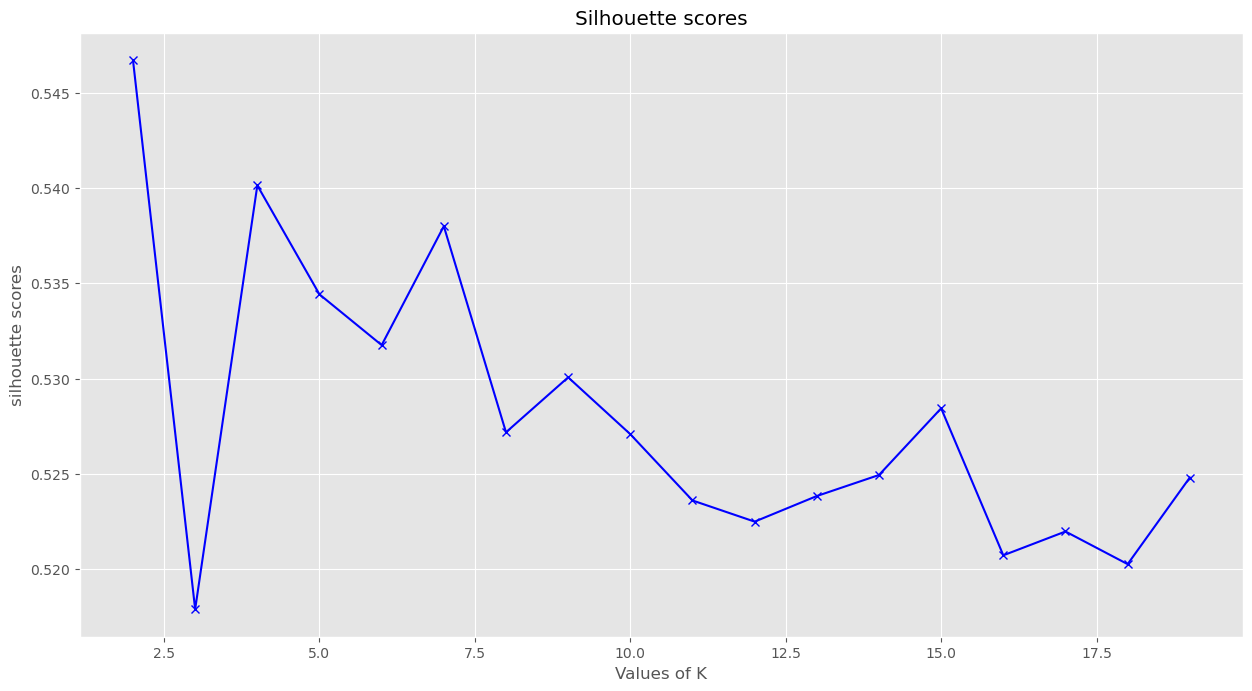

In [26]:
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('silhouette scores')
plt.title('Silhouette scores')
plt.show()

In [29]:
gmm = GaussianMixture(n_components = 4)
gmm.fit(pv_out)

pred_clusters = gmm.predict(pv_out)
silhouette = silhouette_score(pv_out,pred_clusters)
silhouette_scores.append(silhouette)
print("Silhouette score for number of cluster(s) {}: {}".format(4,silhouette))

Silhouette score for number of cluster(s) 4: 0.5396054356905962


In [30]:
set(pred_clusters)

{0, 1, 2, 3}

In [31]:
ph_cluster_gmm = ph.copy()
ph_cluster_gmm['Cluster'] = pred_clusters + 1

Text(0.5, 1.0, 'Barangays Clustered for PVOUT')

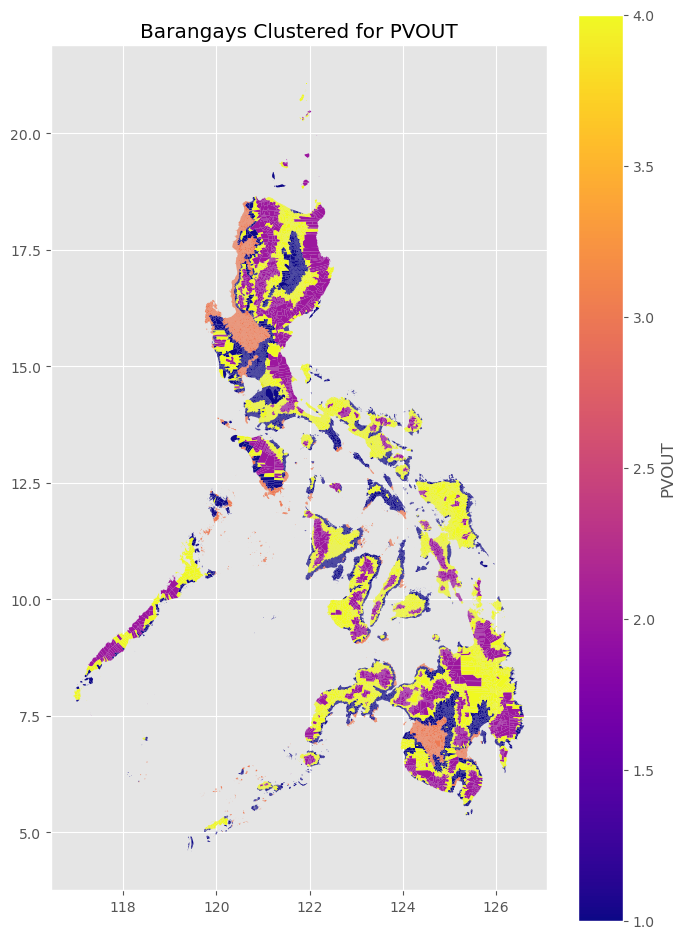

In [32]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_gmm.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Barangays Clustered for PVOUT')

In [33]:
ph_cluster_gmm.to_file(driver='GeoJSON', filename = "ph_clustered_gmm.geojson")

In [34]:
ph_cluster_gmm.to_file(driver='GeoJSON', filename = "ph_clustered_gmm.geojson")

In [35]:
pv_out_per_cluster_summary = ph_cluster_gmm.groupby('Cluster').agg({'COMP_PVOUT_MEAN': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

COMP_PVOUT_MEAN                                 
                   mean          min          max  count
Cluster                                                 
1           1395.848664  1317.782516  1496.998240  14224
2           1016.244049   177.000000  1116.649509   3633
3           1592.212806  1497.011778  1752.060559   6532
4           1235.451703  1116.702112  1317.770699  17544

### DBScan

In [67]:
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors_fit = neighbors.fit(pv_out)
distances, indices = neighbors_fit.kneighbors(pv_out)

**Knee Plot**

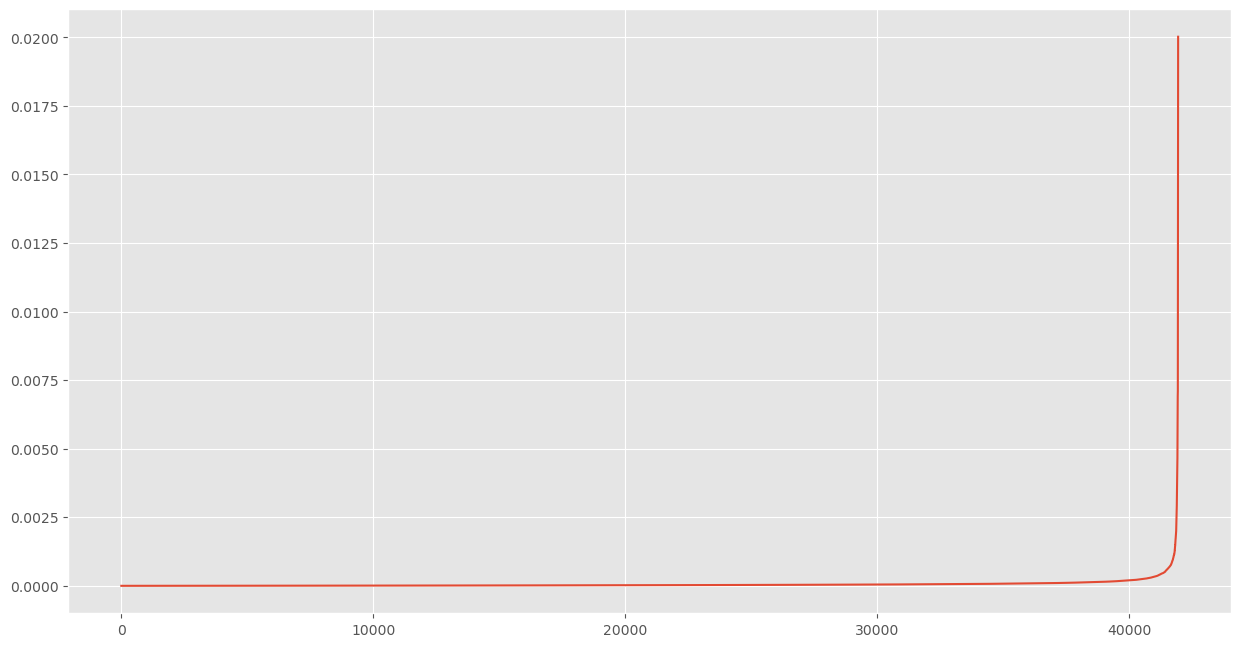

In [68]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

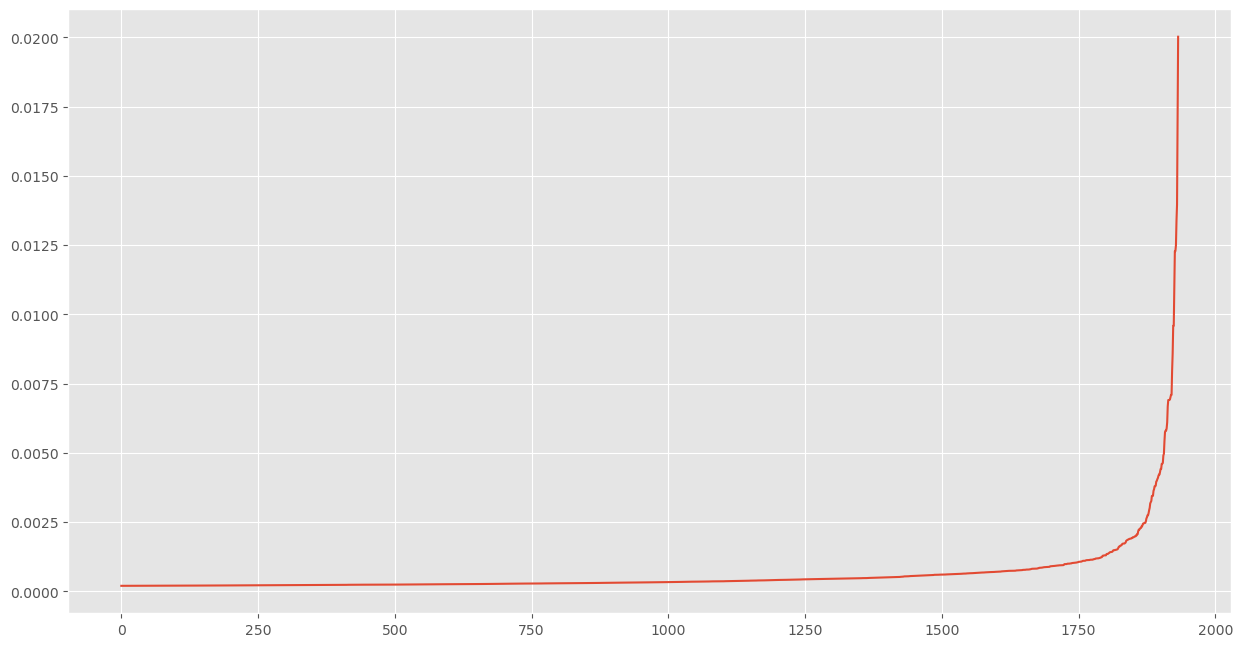

In [69]:
distances = distances[40000:42000]
plt.plot(distances)

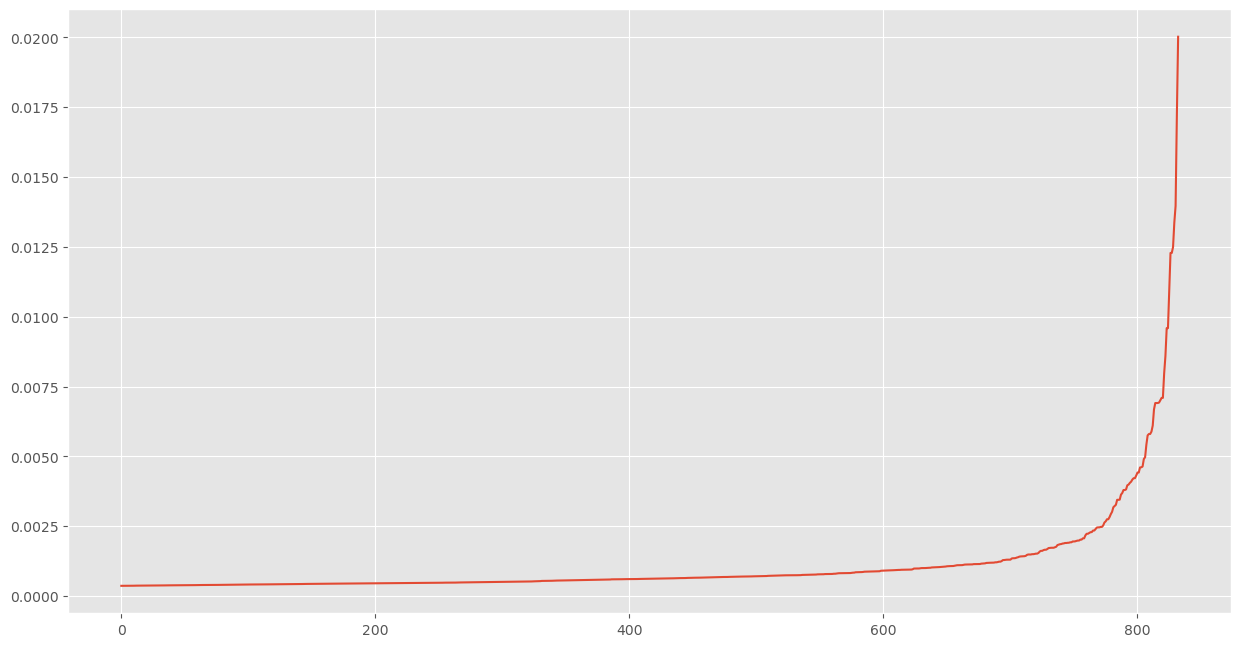

In [70]:
distances = distances[1100:1999]
plt.plot(distances)

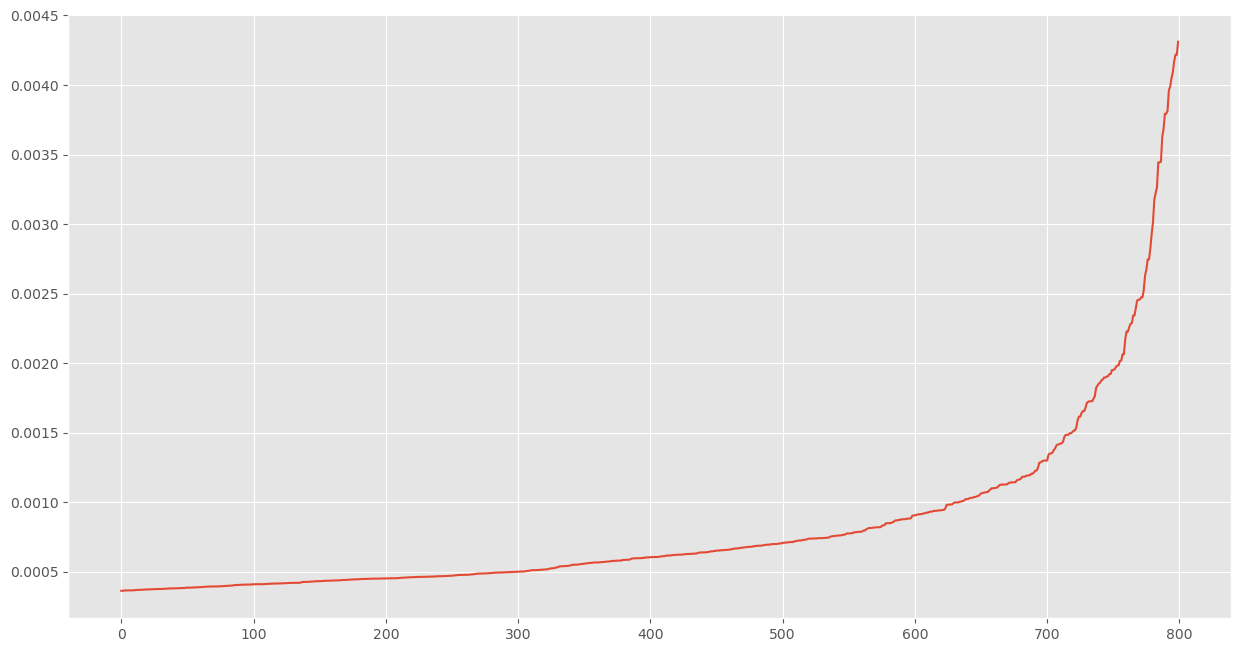

In [71]:
distances = distances[0:800]
plt.plot(distances)

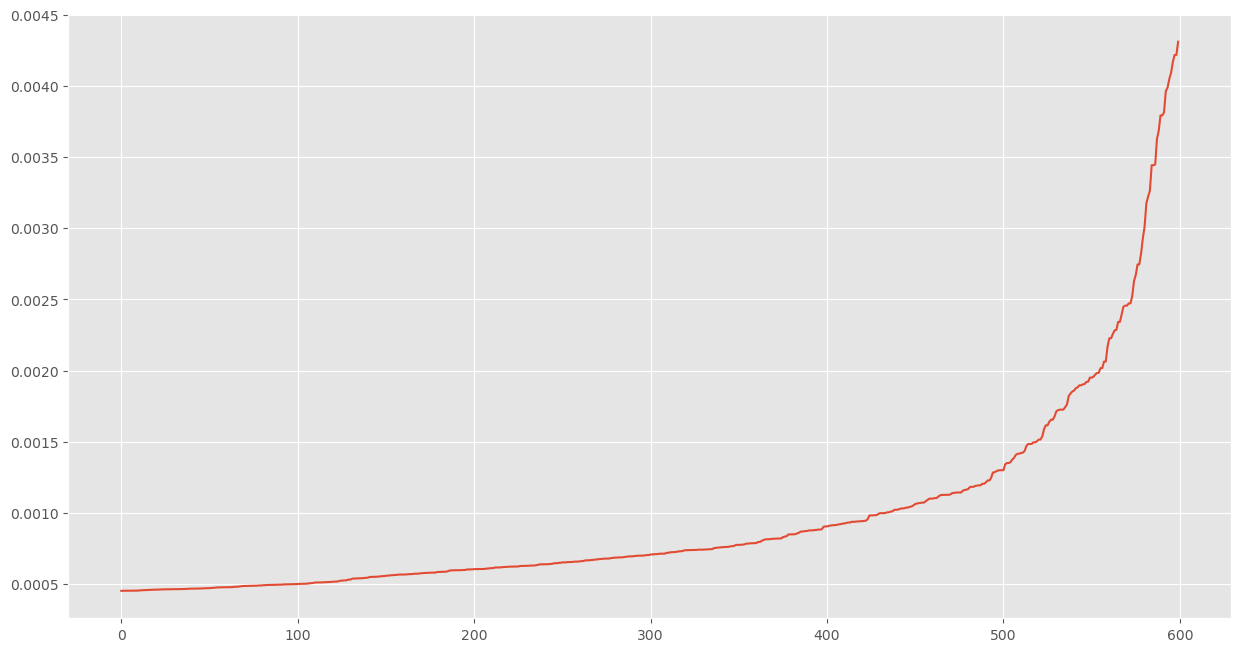

In [72]:
distances = distances[200:800]
plt.plot(distances)

In [74]:
len(distances)

600

In [75]:
silhouette_scores_dbscan = []

for eps in distances:
    
    # Building and fitting the model
    db = DBSCAN(eps = eps, min_samples = 20)
    db.fit(pv_out)
    
    pred_clusters = db.labels_
    n_clusters    = len(set(pred_clusters))
    if n_clusters > 1:
        silhouette_dbscan = silhouette_score(pv_out,pred_clusters)
        silhouette_scores_dbscan.append(silhouette_dbscan)
        print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette_dbscan))
        
    else:
        print("No Silhouette score for eps {} with number of cluster(s) {}".format(eps, n_clusters))

Silhouette score for eps 0.0004528125495701918 with number of cluster(s) 387: -0.14046101700177133
Silhouette score for eps 0.00045332031167366615 with number of cluster(s) 385: -0.13925806208461827
Silhouette score for eps 0.0004534070265140855 with number of cluster(s) 385: -0.13925806208461827
Silhouette score for eps 0.0004534070265140855 with number of cluster(s) 385: -0.13925806208461827
Silhouette score for eps 0.00045341072809046423 with number of cluster(s) 385: -0.13925806208461827
Silhouette score for eps 0.00045391272995276566 with number of cluster(s) 383: -0.13922401721886804
Silhouette score for eps 0.00045391272995276566 with number of cluster(s) 383: -0.13922401721886804
Silhouette score for eps 0.00045395552235238945 with number of cluster(s) 383: -0.1392837539035591
Silhouette score for eps 0.00045395552235238945 with number of cluster(s) 383: -0.1392837539035591
Silhouette score for eps 0.00045410691179004203 with number of cluster(s) 383: -0.13891081117403853
Silho

Silhouette score for eps 0.0004942919547303859 with number of cluster(s) 356: -0.12781002390967552
Silhouette score for eps 0.0004944672608946377 with number of cluster(s) 357: -0.13073007198303593
Silhouette score for eps 0.0004944672608946377 with number of cluster(s) 357: -0.13073007198303593
Silhouette score for eps 0.0004945907409934502 with number of cluster(s) 356: -0.13026464833880713
Silhouette score for eps 0.0004953854354119436 with number of cluster(s) 353: -0.1324443726490555
Silhouette score for eps 0.0004953854354119436 with number of cluster(s) 353: -0.1324443726490555
Silhouette score for eps 0.0004958524674529841 with number of cluster(s) 352: -0.13193877484331526
Silhouette score for eps 0.0004961779399901278 with number of cluster(s) 352: -0.1297376176382449
Silhouette score for eps 0.0004963284776091648 with number of cluster(s) 351: -0.13058972794799212
Silhouette score for eps 0.0004978855888413403 with number of cluster(s) 347: -0.1346482059266484
Silhouette sco

Silhouette score for eps 0.0005729206132978337 with number of cluster(s) 231: -0.09968379293085103
Silhouette score for eps 0.0005732289226925147 with number of cluster(s) 231: -0.10945410748214494
Silhouette score for eps 0.0005748443731377062 with number of cluster(s) 233: -0.10832167960040041
Silhouette score for eps 0.0005766768133033118 with number of cluster(s) 231: -0.10670961005746522
Silhouette score for eps 0.0005775198987287844 with number of cluster(s) 228: -0.10405287128749284
Silhouette score for eps 0.0005786531659150995 with number of cluster(s) 227: -0.10508900679350383
Silhouette score for eps 0.0005786531659150995 with number of cluster(s) 227: -0.10508900679350383
Silhouette score for eps 0.0005795054135033784 with number of cluster(s) 224: -0.10541324299532832
Silhouette score for eps 0.0005800703852933964 with number of cluster(s) 225: -0.10502772560725578
Silhouette score for eps 0.0005800829252784467 with number of cluster(s) 225: -0.10502772560725578
Silhouette

Silhouette score for eps 0.0006527679298653499 with number of cluster(s) 189: -0.10189045022999922
Silhouette score for eps 0.0006527679298653499 with number of cluster(s) 189: -0.10189045022999922
Silhouette score for eps 0.0006546620857776908 with number of cluster(s) 190: -0.10108132321817678
Silhouette score for eps 0.0006546620857776908 with number of cluster(s) 190: -0.10108132321817678
Silhouette score for eps 0.0006550579458850514 with number of cluster(s) 190: -0.10108132321817678
Silhouette score for eps 0.0006562618154299926 with number of cluster(s) 188: -0.09987818230309507
Silhouette score for eps 0.0006577446960487343 with number of cluster(s) 182: -0.1229840554601728
Silhouette score for eps 0.0006577446960487343 with number of cluster(s) 182: -0.1229840554601728
Silhouette score for eps 0.0006587248695588688 with number of cluster(s) 182: -0.126025582310287
Silhouette score for eps 0.000660532914080747 with number of cluster(s) 182: -0.12576402079912768
Silhouette scor

Silhouette score for eps 0.0007448432276457861 with number of cluster(s) 153: -0.0071026572418019275
Silhouette score for eps 0.0007461286227501418 with number of cluster(s) 154: -0.006297864588604056
Silhouette score for eps 0.0007532572096091705 with number of cluster(s) 157: -0.0008188764496949368
Silhouette score for eps 0.0007542494929397847 with number of cluster(s) 158: -6.313603889505009e-05
Silhouette score for eps 0.0007564132538102619 with number of cluster(s) 156: -0.004845067840768977
Silhouette score for eps 0.0007576595476437298 with number of cluster(s) 156: -0.004490180832965295
Silhouette score for eps 0.0007589382395385424 with number of cluster(s) 157: -0.0032990261744151503
Silhouette score for eps 0.0007606518706233523 with number of cluster(s) 157: -0.0006213538042686186
Silhouette score for eps 0.0007606518706233523 with number of cluster(s) 157: -0.0006213538042686186
Silhouette score for eps 0.000760924476717495 with number of cluster(s) 157: -0.00059231846307

Silhouette score for eps 0.0009401448153711911 with number of cluster(s) 136: -0.1806357035947173
Silhouette score for eps 0.0009404148629172937 with number of cluster(s) 136: -0.18060490865806425
Silhouette score for eps 0.0009414085378847137 with number of cluster(s) 136: -0.17977759345323618
Silhouette score for eps 0.0009427423459951179 with number of cluster(s) 137: -0.17891310639455818
Silhouette score for eps 0.0009444267388656336 with number of cluster(s) 137: -0.17853183223555064
Silhouette score for eps 0.0009455375560181167 with number of cluster(s) 136: -0.1790798414727095
Silhouette score for eps 0.0009554866732797151 with number of cluster(s) 135: -0.16581868815201187
Silhouette score for eps 0.000981317411966387 with number of cluster(s) 136: -0.17234641697973915
Silhouette score for eps 0.0009830910205850252 with number of cluster(s) 136: -0.17208541038002304
Silhouette score for eps 0.0009830910205850252 with number of cluster(s) 136: -0.17208541038002304
Silhouette sc

Silhouette score for eps 0.001342128572916934 with number of cluster(s) 99: -0.03789753804833899
Silhouette score for eps 0.0013506904631559458 with number of cluster(s) 100: -0.03498900055989724
Silhouette score for eps 0.0013506904631559458 with number of cluster(s) 100: -0.03498900055989724
Silhouette score for eps 0.0013571455109642194 with number of cluster(s) 100: -0.03472227817218264
Silhouette score for eps 0.0013752996736897671 with number of cluster(s) 98: -0.03173312273334677
Silhouette score for eps 0.0013869244348776455 with number of cluster(s) 102: -0.028853716248214995
Silhouette score for eps 0.0014080739710449208 with number of cluster(s) 99: -0.027625778733833168
Silhouette score for eps 0.0014153447465834468 with number of cluster(s) 98: -0.025312794739615542
Silhouette score for eps 0.0014168293095688789 with number of cluster(s) 98: -0.02514500435093214
Silhouette score for eps 0.001421272251960204 with number of cluster(s) 97: -0.025198073998473777
Silhouette sco

Silhouette score for eps 0.003448237951768185 with number of cluster(s) 24: 0.10946661063323629
Silhouette score for eps 0.003628008470974553 with number of cluster(s) 23: 0.11875573643069401
Silhouette score for eps 0.0036850352247581597 with number of cluster(s) 23: 0.12035801762750359
Silhouette score for eps 0.003793322011731881 with number of cluster(s) 22: 0.11934309832619291
Silhouette score for eps 0.003793322011731881 with number of cluster(s) 22: 0.11934309832619291
Silhouette score for eps 0.003814220090410547 with number of cluster(s) 22: 0.11934309832619291
Silhouette score for eps 0.00396280582219477 with number of cluster(s) 21: 0.12027122021659169
Silhouette score for eps 0.003988620822646283 with number of cluster(s) 20: 0.12004482577996245
Silhouette score for eps 0.0040495869178194255 with number of cluster(s) 20: 0.12155699347296403
Silhouette score for eps 0.004092384836571927 with number of cluster(s) 20: 0.12290256376386315
Silhouette score for eps 0.004169582090

In [76]:
 np.max(silhouette_scores_dbscan)

0.2747088328472312

In [77]:
eps_optimal = distances[np.argmax(silhouette_scores_dbscan, axis=0)]
print("Optimal eps for Silhouette score of {}: {}".format(np.max(silhouette_scores_dbscan), eps_optimal))

Optimal eps for Silhouette score of 0.2747088328472312: 0.002929548992817832


In [78]:
dbscan = DBSCAN(eps = eps_optimal, min_samples = 20)
dbscan.fit(pv_out)

pred_clusters = dbscan.labels_
n_clusters    = len(set(pred_clusters))

silhouette = silhouette_score(pv_out,pred_clusters)
silhouette_scores.append(silhouette)
print("Silhouette score for eps {} with number of cluster(s) {}: {}".format(eps, n_clusters, silhouette))

Silhouette score for eps 0.004311001451420271 with number of cluster(s) 19: 0.2747088328472312


In [79]:
set(pred_clusters)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [80]:
ph_cluster_dbscan = ph.copy()
ph_cluster_dbscan['Cluster'] = pred_clusters + 2

Text(0.5, 1.0, 'Barangays Clustered for PVOUT')

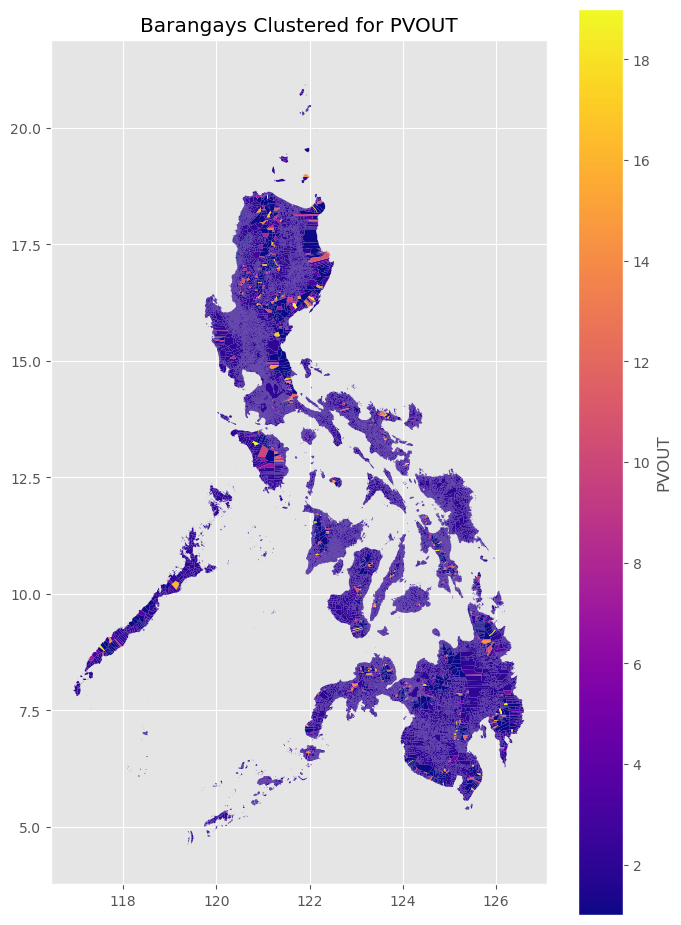

In [81]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_dbscan.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Barangays Clustered for PVOUT')

In [82]:
ph_cluster_dbscan.to_file(driver='GeoJSON', filename = "ph_clustered_dbscan.geojson")

In [83]:
ph_cluster_dbscan.to_file(driver = 'ESRI Shapefile', filename= "ph_clustered_dbscan.shp")

In [84]:
pv_out_per_cluster_summary = ph_cluster_dbscan.groupby('Cluster').agg({'COMP_PVOUT_MEAN': ['mean', 'min', 'max','count']})
pv_out_per_cluster_summary

COMP_PVOUT_MEAN                                 
                   mean          min          max  count
Cluster                                                 
1           1142.469022   177.000000  1752.060559   1866
2           1344.050595  1079.319705  1680.979028  38858
3           1050.199253  1045.406915  1055.132090    183
4           1071.564527  1063.702235  1079.175842    351
5           1037.008979  1035.338688  1038.623697     57
6            996.618215   995.818029   997.524560     30
7           1019.629210  1018.137424  1021.190572     52
8           1042.492215  1041.110249  1043.863598     47
9           1059.788453  1055.935845  1063.499459    175
10          1012.245102  1011.043239  1013.536853     42
11          1031.208399  1030.545219  1032.066545     31
12          1026.920527  1025.242464  1028.743240     63
13          1015.650660  1014.514950  1016.733481     36
14          1023.526558  1022.443793  1024.768187     39
15           980.985719   980.419017   981.684206     24
16           969.615018   968.966828   970.184463     22
17          1029.368130  1028.941381  1029.717380     16
18          1004.109535  1003.504757  1004.698966     21
19           990.747768   990.139024   991.352029     20

## Comparison of Silhouette Scores 

|**Model**|**Silhouette Scores**|**Number of Clusters**|
|:-|------|------|
|K Means Clustering Model  |0.54013     |4     |
|GMM     |0.5396     |4     |
|DBScan     |0.2747     |19     |

The model with the highest silhouette score is the K Means Clustering Model with 4 groups. The Average PVOut data for the barangays will be clustered into 4 total groups 

In [87]:
pv_out_per_cluster_summary

COMP_PVOUT_MEAN                                 
                   mean          min          max  count
Cluster                                                 
1           1237.820123  1134.904783  1313.497625  16373
2           1585.674600  1487.804347  1752.060559   6991
3           1390.072915  1313.516610  1487.778286  14236
4           1033.996477   177.000000  1134.827519   4333